In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
from scipy.integrate import quad
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import copy
import calendar
from optimise_GDD_fctns import * #Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array

#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [ ]:
def local_opt(x1s, train, test, error_fctn = run_GDD_and_get_RMSE, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], #ds
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True, CCNN_split = False, test_size = 0.5, random_state=1, itr = 0.5, bias_term = False):
    #if split:
    #    train, test = train_test_split(ds, test_size=test_size, random_state = random_state)
    #    #train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
    #elif CCNN_split:
    #    test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
    #    train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    complement_indices = ds.index.difference(test.index)
    #
    #    # Filter df2 to keep only the rows with the complement indices
    #    train = ds.loc[complement_indices]
    #    #train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #else:
    #    train = ds
    #    test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang' or response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0, 0], [0, 0, -1, 1, 0, 0]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Spline':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2],
                                                x[3]]),
                    'jac' : lambda x: np.array([[0 for count in range(20)],
                                                [0 for count in range(20)]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0 for count in range(20)], [0 for count in range(20)]]),lb= [-1, -1], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    jac='3-point',#
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', #jac='3-point',#[x0/1000 for x0 in 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#
                                    constraints=[constraints],
                                    options={'verbose': 3, 'initial_tr_radius': itr, 'xtol':1e-7, 'maxiter':maxiter},# ,'gtol':1e-7, 'finite_diff_rel_step': 0.05
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':maxiter, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Powell':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Powell',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
        print(x0, res.x, x0 - res.x)
        RMSE = error_fctn(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds)
        #print('R^2: ', r2_score(c_array[f'observed time to {only_phase}'], c_array[f'modelled time to {only_phase}']))
        print('RMSE at opt on test set: ', RMSE)
        print('R^2:', 1 - (RMSE**2/(test[f'observed time to {only_phase}'].var()*((len(test) - 1)/len(test)))))
        final_mins.append(res.x)
    return final_mins, res, train, test

In [ ]:
def KFold_crossval(ds, k_folds, method = 'Nelder-Mead'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')

        x1s = [np.array([0.5, 8, 28, 39])]
        print(f'Fold {fold + 1}')
        fm = local_opt(x1s, train, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method=method,
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.02)
        print('Parameters: ', fm)

        comparison_array = run_GDD_and_plot(fm[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')
        comparison_array['Error'] = comparison_array['observed time to beginning of flowering'] - comparison_array['modelled time to beginning of flowering']

        r2_score_model = r2_score(comparison_array['observed time to beginning of flowering'], comparison_array['modelled time to beginning of flowering'])
        bias_model = (comparison_array['Error']).mean()
        variance = comparison_array['modelled time to beginning of flowering'].var()

        RMSE = np.sqrt(np.mean((comparison_array['Error'] - bias_model)**2))
        STD = comparison_array['modelled time to beginning of flowering'].std() 
        Corr = comparison_array['observed time to beginning of flowering'].corr(comparison_array['modelled time to beginning of flowering'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_array['Error'].min())
        LQs.append(comparison_array['Error'].quantile(0.25))
        Medians.append(comparison_array['Error'].median())
        UQs.append(comparison_array['Error'].quantile(0.75))
        Maxs.append(comparison_array['Error'].max())

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [ ]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [ ]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE = ds_inputs_DE.drop(columns = [col for col in ds_inputs_DE.columns if vble in col])

In [ ]:
x1s = [np.array([0.5, 8, 25, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE2 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 error_fctn=run_GDD_transformed_space_error2,
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [200], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 16.672466
         Iterations: 492
         Function evaluations: 788
[ 0.5  8.  25.  39. ] [ 2.74017663  7.         20.         40.        ] [-2.24017663  1.          5.         -1.        ]
RMSE at opt on test set:  15.613883465771611
R^2: -1.360334624900076


In [ ]:
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], fm_flowering_all_DE[-2],
                         error_fctn = run_GDD_transformed_space_error,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [200], title = ' initial T_opt 25', plot_range = 0.5)

In [ ]:
x1s = [np.array([1.5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE3 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 error_fctn=run_GDD_transformed_space_error3,
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [60], growing_period_length=300,
                     test_size = 0.2, maxiter = 10, random_state = 1)

In [ ]:
x1s = [np.array([0.5, 8, 28, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = fm_flowering_all_DE4[0]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
fm_flowering_all_DE4 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 #error_fctn=run_GDD_supplemented_error,
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 3.616186
         Iterations: 207
         Function evaluations: 366
[ 0.5  8.  28.  39. ] [ 0.36880762  7.         24.55907399 38.50000003] [0.13119238 1.         3.44092601 0.49999997]
RMSE at opt on test set:  3.609131665036277
R^2: 0.894573754307085
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.39283123429479594
Bias: 0.5500576607981985 (sign 1.0)
Variance of modelled values: 79.82890102533095
Optimization terminated successfully.
         Current function value: 3.615278
         Iterations: 361
         Function evaluations: 599
[ 0.5  8.  28.  39. ] [ 0.36575853  7.68277472 24.04749414 38.50020311] [0.13424147 0.31722528 3.95250586 0.49979689]
RMSE at opt on test set:  3.607779211713014
R^2: 0.8946527524563599
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3908483337841314
Bias: 0.5152748861551271 (s

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7360\3957145699.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m',


[ 0.5  8.  28.  39. ] [ 0.40685036  7.10115272 24.3249104  39.9996831 ] [ 0.09314964  0.89884728  3.6750896  -0.9996831 ]
RMSE at opt on test set:  3.5842148155562517
R^2: 0.8960244201907077
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.39675074191898896
Bias: 0.4684873968671461 (sign 1.0)
Variance of modelled values: 71.2919501670074
Optimization terminated successfully.
         Current function value: 3.580316
         Iterations: 201
         Function evaluations: 377
[ 0.5  8.  28.  39. ] [ 0.51007253  8.37411471 24.82731736 39.03118264] [-0.01007253 -0.37411471  3.17268264 -0.03118264]
RMSE at opt on test set:  3.59563765606748
R^2: 0.8953606268010117
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3399024502358118
Bias: 0.7101556614361371 (sign 1.0)
Variance of modelled values: 93.75177559143913


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7360\3957145699.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m',


[ 0.5  8.  28.  39. ] [ 0.45276256  7.0124681  23.15268864 38.52176233] [0.04723744 0.9875319  4.84731136 0.47823767]
RMSE at opt on test set:  3.5565802843318477
R^2: 0.8976215564256514
0 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.38467588083264637
Bias: 0.21025153557657122 (sign 1.0)
Variance of modelled values: 64.14981006993203


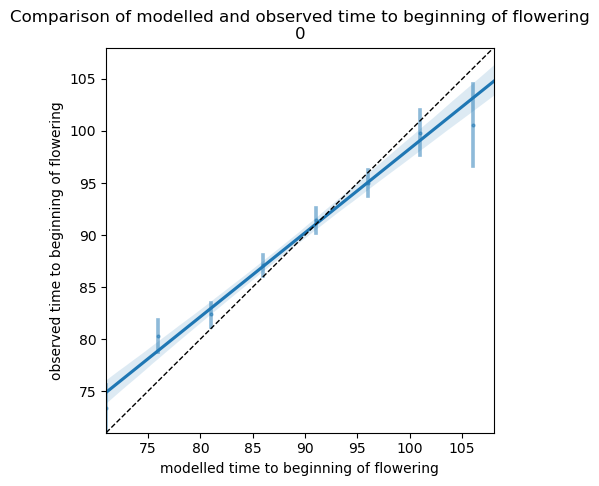

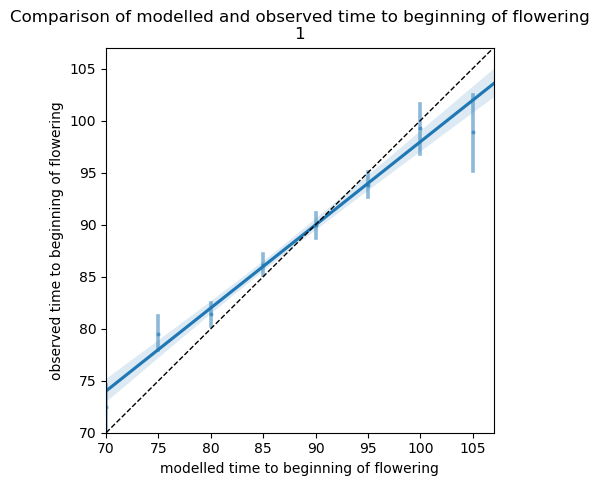

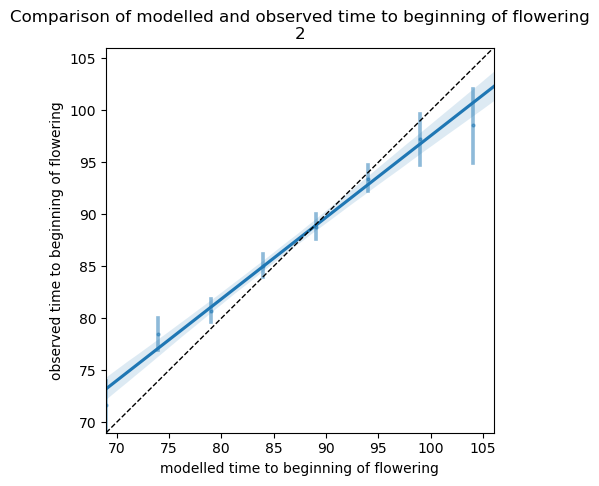

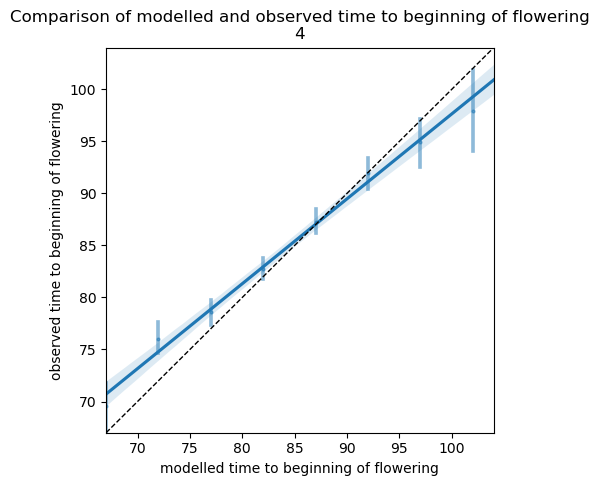

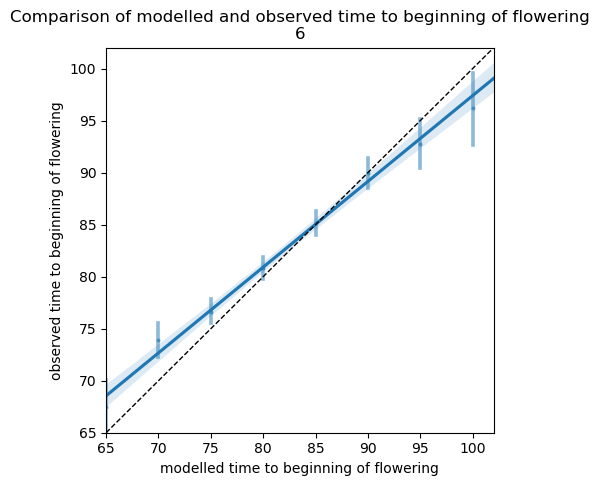

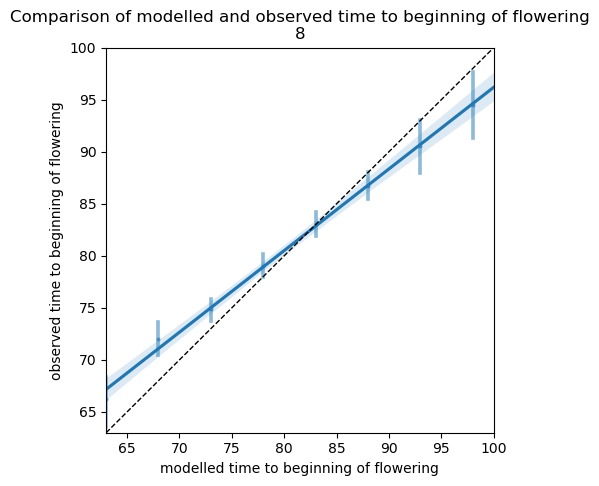

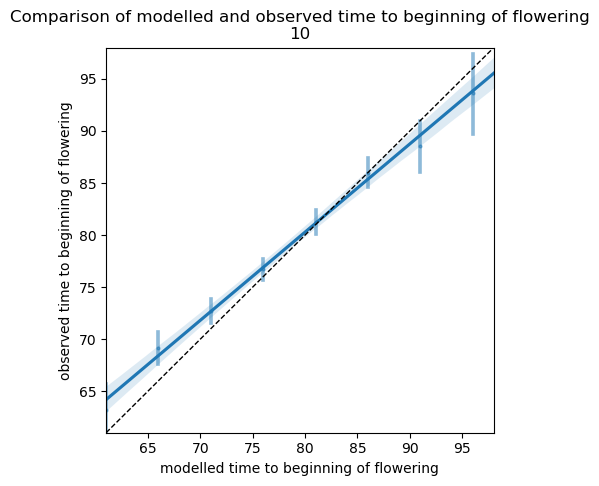

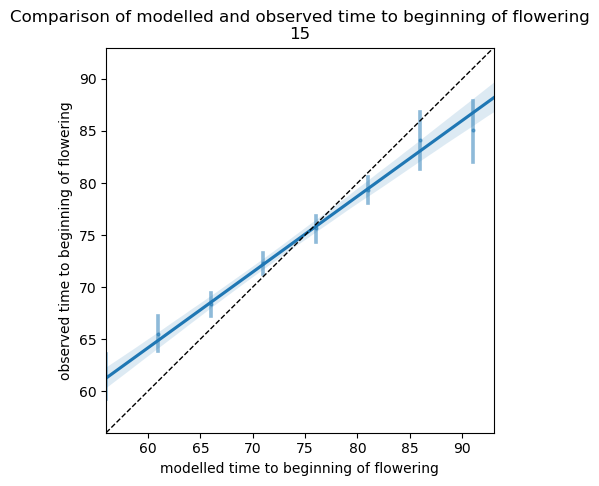

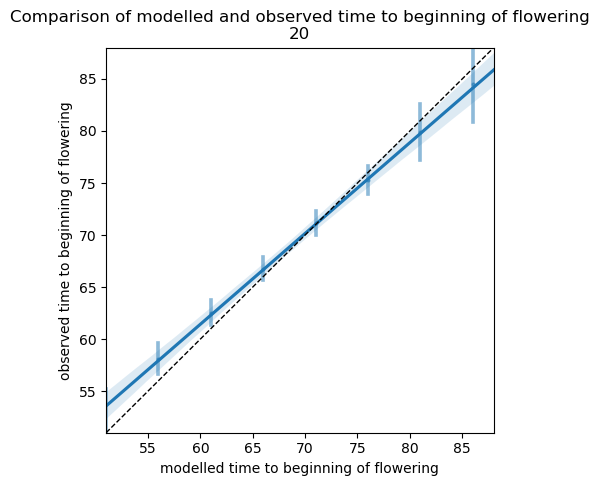

In [ ]:
fm_shifted = []
comparison_array_shifted = []
x1s = [np.array([0.5, 8, 28, 39])]
for flowering_shift in [0, 1, 2, 4, 6, 8, 10, 15, 20]:
    ds_inputs_DE_shifted = ds_inputs_DE_reduced.copy()
    ds_inputs_DE_shifted['observed time to beginning of flowering'] = ds_inputs_DE_shifted['observed time to beginning of flowering'] - flowering_shift
    train_a, test_a = train_test_split(ds_inputs_DE_shifted, test_size=0.2, random_state = 1)
    fm_shift = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                         error_fctn=run_GDD_transformed_space_error3,
                         lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                         great_threshold = 13, response_type = 'Wang',
                         phase_list = ['beginning of flowering'],
                         method='Nelder-Mead',
                         thresholds = [20], growing_period_length=300,
                         test_size = 0.2, maxiter = 50, random_state = 1)
    fm_shifted.append(fm_shift)
    comparison_array_shift = run_GDD(fm_shift[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                            thresholds = [20], title_extra=str(flowering_shift), method = 'regression', plot=True)
    comparison_array_shifted.append(comparison_array_shift)
    


In [ ]:
x1s = [np.array([0.5, 8, 28, 39, 0.5])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = fm_flowering_all_DE4[0]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_all_DE5 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 #error_fctn = run_GDD_and_get_RMSE_bias_term, #error_fctn=run_GDD_supplemented_error,
                     lower_bounds = [0.01, 7, 20, 38.5, -2], upper_bounds = [5, 11, 31, 40, 2],
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 10, random_state = 1, itr = 0.01, bias_term = True)

Optimization terminated successfully.
         Current function value: 8.371502
         Iterations: 116
         Function evaluations: 226
[ 0.5  8.  28.  39.   0.5] [ 0.44932428  7.23906059 26.14758185 39.08231653  0.55529453] [ 0.05067572  0.76093941  1.85241815 -0.08231653 -0.05529453]
RMSE at opt on test set:  8.41516856419258
R^2: 0.4238991804408617


In [ ]:
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_all_DE5 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                                 #error_fctn = run_GDD_and_get_RMSE_bias_term, #error_fctn=run_GDD_supplemented_error,
                     lower_bounds = [0.01, 7, 20, 38.5, -2], upper_bounds = [5, 11, 31, 40, 2],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 10, random_state = 1, itr = 0.01, bias_term = True)

Optimization terminated successfully.
         Current function value: 8.363051
         Iterations: 134
         Function evaluations: 263
[ 0.5  8.  28.  39.   0.5] [ 0.31484962  7.01347729 22.98066462 39.20942413  0.91725853] [ 0.18515038  0.98652271  5.01933538 -0.20942413 -0.41725853]
RMSE at opt on test set:  8.46475336740652
R^2: 0.42007489850941215


In [ ]:
plot_profiles_at_minimum(fm_flowering_all_DE5[0][0], fm_flowering_all_DE5[-2],
                         error_fctn = run_GDD_and_get_RMSE_bias_term,#error_fctn = run_GDD_supplemented_error,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5, -10], ub = [5, 11, 31, 40, 10], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 25', plot_range = 0.25, bias_term = True)

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


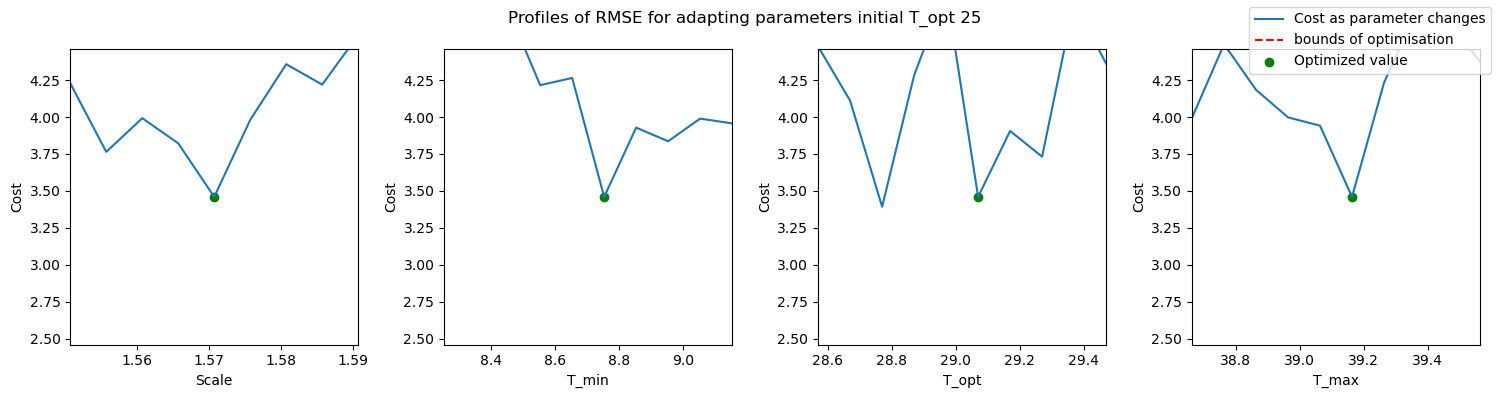

In [ ]:
plot_profiles_at_minimum(fm_flowering_all_DE3[0][0], fm_flowering_all_DE3[-2],
                         error_fctn = run_GDD_transformed_space_error3,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [60], title = ' initial T_opt 25', plot_range = 1)